<a href="https://colab.research.google.com/github/kevin-brand/rule-evaluation-tool/blob/master/ruleevaluationtool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 30.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=34822afe514cf7d4b21a8dfd06a5e4800b8bcea8095abf5901959d2c2180ed0e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from google.colab import drive
from google.colab import files

# Pretty display for notebooks
%matplotlib inline

In [ ]:
# Load Data Set
drive.mount('/content/drive')
# You need to add your own pre-processed version of the boston housing data here!!! (yeah, i should have done all the processing here...oh well)
data = pd.read_csv('/content/drive/MyDrive/Uni/BA/Data/boston-housing-data-preprocessed.csv', sep=',')
target = data['MEDV']
features = data.drop('MEDV', axis = 1)

# Success
print("Sucess! The dataset has {} data points with {} variables each.".format(*data.shape))

Mounted at /content/drive
Sucess! The dataset has 491 data points with 11 variables each.


In [ ]:
# Import 'r2_score'

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [ ]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


In [ ]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
# NOTE: You have to re-do this step until you get a optimal max_depth of 5!
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 5 for the optimal model.


In [ ]:
def calculate_user_prediction(input_data, rules, strong_magnitude, weak_magnitude, strong_magnitude_decrease_step, weak_magnitude_decrease_step):

  # List of features
  features = [
        "CRIM",
        "ZN",
        "INDUS",
        "RM",
        "AGE",
        "DIS",
        "RAD",
        "TAX",
        "PTRATIO",
        "LSTAT"
    ]

  # Config Values
  avg_value = 20.85 # Average prediction value. Based on the data set 
  strong_magnitude_lower_bound = 0 # Makes sure that the strong magnitude stays above 0
  weak_magnitude_lower_bound = 0 # Makes sure that the weak magnitude stays above 0

  # Init prediction
  user_prediction = avg_value # Default prediction is the average prediction.

  # Loop over every rule
  for i in range(len(rules)):
    magnitude = 0
    effect = 0

    # Decide which magnitude value to use
    if rules[i]['magnitude'] == 'STRONG':
      magnitude = strong_magnitude
      strong_magnitude -= strong_magnitude_decrease_step
      if strong_magnitude <= strong_magnitude_lower_bound:
        strong_magnitude = strong_magnitude_lower_bound
    else:
      magnitude = weak_magnitude
      weak_magnitude -= weak_magnitude_decrease_step
      if weak_magnitude <= weak_magnitude_lower_bound:
        weak_magnitude = weak_magnitude_lower_bound

    # Decide wheter or not the effect is positive or negative
    if rules[i]['effect'] == 'POSITIVE':
      effect = 1
    else:
      effect = -1

    # Check for rules of type: Feature Comparison Value and change prediction if the rule is true
    if rules[i]['value'] not in features:
      if rules[i]['comparison'] == 'GREATER':
        if float(input_data[rules[i]['feature']]) > float(rules[i]['value']):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'GREATER EQUAL':
        if float(input_data[rules[i]['feature']]) >= float(rules[i]['value']):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'EQUAL':
        if float(input_data[rules[i]['feature']]) == float(rules[i]['value']):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'NOT EQUAL':
        if float(input_data[rules[i]['feature']]) != float(rules[i]['value']):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'LESS':
        if float(input_data[rules[i]['feature']]) < float(rules[i]['value']):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'LESS EQUAL':
        if float(input_data[rules[i]['feature']]) <= float(rules[i]['value']):
          user_prediction += magnitude * effect

    # Check for rules of type: Feature Comparison Feature and change prediction if the rule is true
    if rules[i]['value'] in features:
      if rules[i]['comparison'] == 'GREATER':
        if float(input_data[rules[i]['feature']]) > float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'GREATER EQUAL':
        if float(input_data[rules[i]['feature']]) >= float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect
      
      if rules[i]['comparison'] == 'EQUAL':
        if float(input_data[rules[i]['feature']]) == float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'NOT EQUAL':
        if float(input_data[rules[i]['feature']]) != float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect
      
      if rules[i]['comparison'] == 'LESS':
        if float(input_data[rules[i]['feature']]) < float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect

      if rules[i]['comparison'] == 'LESS EQUAL':
        if float(input_data[rules[i]['feature']]) <= float(input_data[rules[i]['value']]):
          user_prediction += magnitude * effect

  # Returns the final value  
  return user_prediction

In [ ]:
def get_number_of_used_rules(input_data, rules):
  features = [
        "CRIM",
        "ZN",
        "INDUS",
        "RM",
        "AGE",
        "DIS",
        "RAD",
        "TAX",
        "PTRATIO",
        "LSTAT"
    ]
  num_used_rules = 0

  for i in range(len(rules)):
    # Check for rules of type: Feature Comparison Value
    if rules[i]['value'] not in features:
      if rules[i]['comparison'] == 'GREATER':
        if float(input_data[rules[i]['feature']]) > float(rules[i]['value']):
          num_used_rules += 1

      if rules[i]['comparison'] == 'GREATER EQUAL':
        if float(input_data[rules[i]['feature']]) >= float(rules[i]['value']):
          num_used_rules += 1

      if rules[i]['comparison'] == 'EQUAL':
        if float(input_data[rules[i]['feature']]) == float(rules[i]['value']):
          num_used_rules += 1

      if rules[i]['comparison'] == 'NOT EQUAL':
        if float(input_data[rules[i]['feature']]) != float(rules[i]['value']):
          num_used_rules += 1

      if rules[i]['comparison'] == 'LESS':
        if float(input_data[rules[i]['feature']]) < float(rules[i]['value']):
          num_used_rules += 1

      if rules[i]['comparison'] == 'LESS EQUAL':
        if float(input_data[rules[i]['feature']]) <= float(rules[i]['value']):
          num_used_rules += 1

  # Check for rules of type: Feature Comparison Feature
    if rules[i]['value'] in features:
      if rules[i]['comparison'] == 'GREATER':
        if float(input_data[rules[i]['feature']]) > float(input_data[rules[i]['value']]):
          num_used_rules += 1

      if rules[i]['comparison'] == 'GREATER EQUAL':
        if float(input_data[rules[i]['feature']]) >= float(input_data[rules[i]['value']]):
          num_used_rules += 1
    
      if rules[i]['comparison'] == 'EQUAL':
        if float(input_data[rules[i]['feature']]) == float(input_data[rules[i]['value']]):
          num_used_rules += 1

      if rules[i]['comparison'] == 'NOT EQUAL':
        if float(input_data[rules[i]['feature']]) != float(input_data[rules[i]['value']]):
          num_used_rules += 1
      
      if rules[i]['comparison'] == 'LESS':
        if float(input_data[rules[i]['feature']]) < float(input_data[rules[i]['value']]):
          num_used_rules += 1

      if rules[i]['comparison'] == 'LESS EQUAL':
        if float(input_data[rules[i]['feature']]) <= float(input_data[rules[i]['value']]):
          num_used_rules += 1
    
  return num_used_rules

In [ ]:
def create_rules_from_string(json_string):
  json_data = json.loads(json_string)
  name = json_data['name']
  rules = json_data['rules']
  return (name, rules)

In [ ]:
import json
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(training_data = np.array(X_train), mode = "regression", feature_names = X_train.columns, categorical_features = [0])

EMPTY_string = '{"name":"EMPTY", "rules":[]}'
REF_string = '{"name":"_REF_","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"5.88","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20.2","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"2.11","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"5.22","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"93.53","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"LESS EQUAL","value":"46.17","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"GREATER","value":"666","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"LESS EQUAL","value":"277","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"18.1","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"5.13","magnitude":"WEAK","effect":"POSITIVE"}]}'

MANNBRLE_pre_string = '{"name":"MANNBRLE_PRE","rules":[{"feature":"RM","comparison":"GREATER","value":"6.6","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"17","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"4","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"77","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"LESS","value":"80","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"ZN","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER EQUAL","value":"666","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"LESS","value":"247","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"EQUAL","value":"23","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS","value":"2","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"11","magnitude":"WEAK","effect":"POSITIVE"}]}'
MANNBRLE_post_string = ' {"name":"MANNBRLE_POST","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"17","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"10","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"4","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"9","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER EQUAL","value":"6","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"666","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"LESS","value":"287","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"18","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"85","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"LESS","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"30","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"6","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RAD","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"GREATER","value":"3","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"DIS","comparison":"LESS","value":"2","magnitude":"WEAK","effect":"NEGATIVE"}]}'

ANANKARG_pre_string = '{"name":"ANANKARG_PRE","rules":[{"feature":"CRIM","comparison":"GREATER","value":"4","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"18","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"80","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"LESS","value":"20","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"GREATER","value":"3","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"LESS","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"6","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"18","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"22","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"25","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER EQUAL","value":"8","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"600","magnitude":"WEAK","effect":"NEGATIVE"}]}'
ANANKARG_post_string = '{"name":"ANANKARG_POST","rules":[{"feature":"CRIM","comparison":"EQUAL","value":"5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"8","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"1","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"7.25","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"LESS","value":"11.66","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"77.7","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"LESS","value":"46.17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER","value":"8.56","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"GREATER","value":"5.22","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"LESS","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"2.11","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6.63","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"18.9","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"LESS EQUAL","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER EQUAL","value":"8","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"LESS EQUAL","value":"277","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"330","magnitude":"WEAK","effect":"POSITIVE"}]}'

SIASPFPL_pre_string = '{"name":"SIASPFPL_PRE","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"7","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"2","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"19","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"1","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER EQUAL","value":"25","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"LESS EQUAL","value":"400","magnitude":"WEAK","effect":"POSITIVE"}]}'
SIASPFPL_post_string = '{"name":"SIASPFPL_POST","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"11.66","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER EQUAL","value":"6.19","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"5.88","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"19","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"4","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"24","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"2.11","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"5.22","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"LESS EQUAL","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"INDUS","comparison":"LESS","value":"5.13","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"8.56","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER EQUAL","value":"25","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"LESS EQUAL","value":"330","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"666","magnitude":"WEAK","effect":"POSITIVE"}]}'

ANASKALE_pre_string = '{"name":"ANASKALE_PRE","rules":[{"feature":"CRIM","comparison":"GREATER EQUAL","value":"1","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"18","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"7","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"8","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"50","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER EQUAL","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"80","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"1","magnitude":"WEAK","effect":"POSITIVE"}]}'
ANASKALE_post_string = '{"name":"ANASKALE_POST","rules":[{"feature":"RM","comparison":"GREATER","value":"6","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"18","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"LESS","value":"11","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER EQUAL","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"17","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"17","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"1","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"8","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"7","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"50","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"80","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"1","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"6.5","magnitude":"WEAK","effect":"POSITIVE"}]}'

LINGSTND_pre_string = ' {"name":"LINGSTND_PRE","rules":[{"feature":"ZN","comparison":"GREATER","value":"5","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"LESS","value":"1","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"8","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"LESS","value":"2","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"40","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"9","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"0.5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER EQUAL","value":"1","magnitude":"WEAK","effect":"POSITIVE"}]}'
LINGSTND_post_string = '{"name":"LINGSTND_POST","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7.2510","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER","value":"12","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER","value":"1","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"5.88","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"2.11","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"LESS EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"4","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"GREATER","value":"330","magnitude":"WEAK","effect":"POSITIVE"}]}'

KAERDIEN_pre_string = '{"name":"KAERDIEN_PRE","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"9.5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"18","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"DIS","comparison":"GREATER","value":"3.8","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER EQUAL","value":"50","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"15","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"}]}'
KAERDIEN_post_string = '{"name":"KAERDIEN_POST","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"9.5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"9.5","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"7","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"1","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17.5","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"17.5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RAD","comparison":"LESS EQUAL","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"DIS","comparison":"GREATER","value":"2","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER EQUAL","value":"85","magnitude":"WEAK","effect":"POSITIVE"}]}'

BBBBBBBB_pre_string = '{"name":"BBBBBBBB_PRE","rules":[{"feature":"CRIM","comparison":"GREATER","value":"0","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"10","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"60","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"}]}'
BBBBBBBB_post_string = '{"name":"BBBBBBBB_POST","rules":[{"feature":"CRIM","comparison":"GREATER","value":"0","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"6.19","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"60","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"18.9","magnitude":"STRONG","effect":"NEGATIVE"}]}'

TEUTRGCH_pre_string = '{"name":"TEUTRGCH_PRE","rules":[{"feature":"AGE","comparison":"GREATER","value":"95","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"80","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"60","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RAD","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"POSITIVE"}]}'
TEUTRGCH_post_string = '{"name":"TEUTRGCH_POST","rules":[{"feature":"LSTAT","comparison":"LESS","value":"4","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"LESS","value":"8","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"16","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"19","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"17","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"95","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"80","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"60","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RAD","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"20","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"10","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"4","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"POSITIVE"}]}'

CLERKAEN_pre_string = '{"name":"CLERKAEN_PRE","rules":[{"feature":"LSTAT","comparison":"GREATER EQUAL","value":"19","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"10","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"LESS EQUAL","value":"1","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"GREATER","value":"7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"9","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"25","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"LESS EQUAL","value":"5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER EQUAL","value":"666","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"LESS EQUAL","value":"300","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER EQUAL","value":"12","magnitude":"WEAK","effect":"NEGATIVE"}]}'
CLERAKEN_post_string = '{"name":"CLERKAEN_POST","rules":[{"feature":"LSTAT","comparison":"GREATER EQUAL","value":"16.91","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"6.63","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"17","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"20","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"18.1","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"2","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"DIS","comparison":"LESS EQUAL","value":"0.5","magnitude":"WEAK","effect":"NEGATIVE"}]}'

DAARKALE_pre_string = '{"name":"DAARKALE_PRE","rules":[{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"20","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"DIS","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"NOT EQUAL","value":"0","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS","value":"20","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER","value":"15","magnitude":"WEAK","effect":"NEGATIVE"}]}'
DAARKALE_post_string = '{"name":"DAARKALE_POST","rules":[{"feature":"LSTAT","comparison":"GREATER","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER EQUAL","value":"6.01","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"GREATER","value":"DIS","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"17","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER EQUAL","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER","value":"8.5","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"NOT EQUAL","value":"0","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"500","magnitude":"WEAK","effect":"NEGATIVE"}]}'

SAEROFTZ_pre_string = '{"name":"SAEROFTZ_PRE","rules":[{"feature":"TAX","comparison":"GREATER EQUAL","value":"666","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"INDUS","comparison":"GREATER","value":"18","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"9","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"12","magnitude":"WEAK","effect":"POSITIVE"}]}'
SAEROFTZ_post_string = '{"name":"SAEROFTZ_POST","rules":[{"feature":"RM","comparison":"GREATER","value":"6.63","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS EQUAL","value":"6.19","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER EQUAL","value":"96","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS EQUAL","value":"7.25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"DIS","comparison":"LESS","value":"2","magnitude":"STRONG","effect":"NEGATIVE"}]}'

HANKMUPG_pre_string = '{"name":"HANKMUPG_PRE","rules":[{"feature":"CRIM","comparison":"GREATER","value":"2","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"0","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"1.5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"3","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"60.2","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"LSTAT","comparison":"LESS","value":"30.98","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"20","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"TAX","comparison":"GREATER","value":"250","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"ZN","comparison":"GREATER","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER EQUAL","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"PTRATIO","comparison":"LESS EQUAL","value":"10","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"TAX","comparison":"LESS","value":"300","magnitude":"STRONG","effect":"POSITIVE"}]}'
HANKMUPG_post_string = '{"name":"HANKMUPG_POST","rules":[{"feature":"CRIM","comparison":"GREATER","value":"2","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"0","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"CRIM","comparison":"EQUAL","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"0","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER","value":"1.5","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"CRIM","comparison":"GREATER EQUAL","value":"3","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"LESS","value":"6","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.7","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RM","comparison":"LESS","value":"5.99","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"AGE","comparison":"GREATER","value":"60.2","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"AGE","comparison":"GREATER","value":"47","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"LSTAT","comparison":"LESS","value":"30.98","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"LESS","value":"20","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"RAD","comparison":"GREATER","value":"25","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"TAX","comparison":"GREATER","value":"250","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"LESS","value":"300","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"0","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"INDUS","comparison":"GREATER EQUAL","value":"15","magnitude":"STRONG","effect":"NEGATIVE"},{"feature":"TAX","comparison":"GREATER","value":"290","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"ZN","comparison":"LESS","value":"21","magnitude":"WEAK","effect":"NEGATIVE"},{"feature":"RM","comparison":"GREATER","value":"6.6","magnitude":"STRONG","effect":"POSITIVE"},{"feature":"PTRATIO","comparison":"GREATER","value":"17.5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"RAD","comparison":"EQUAL","value":"5","magnitude":"WEAK","effect":"POSITIVE"},{"feature":"ZN","comparison":"GREATER","value":"0.1","magnitude":"WEAK","effect":"POSITIVE"}]}'

rule_set = []
rule_set.append(create_rules_from_string(EMPTY_string))
rule_set.append(create_rules_from_string(REF_string))
rule_set.append(create_rules_from_string(MANNBRLE_pre_string))
rule_set.append(create_rules_from_string(MANNBRLE_post_string))
rule_set.append(create_rules_from_string(ANANKARG_pre_string))
rule_set.append(create_rules_from_string(ANANKARG_post_string))
rule_set.append(create_rules_from_string(SIASPFPL_pre_string))
rule_set.append(create_rules_from_string(SIASPFPL_post_string))
rule_set.append(create_rules_from_string(ANASKALE_pre_string))
rule_set.append(create_rules_from_string(ANASKALE_post_string))
rule_set.append(create_rules_from_string(LINGSTND_pre_string))
rule_set.append(create_rules_from_string(LINGSTND_post_string))
rule_set.append(create_rules_from_string(KAERDIEN_pre_string))
rule_set.append(create_rules_from_string(KAERDIEN_post_string))
rule_set.append(create_rules_from_string(BBBBBBBB_pre_string))
rule_set.append(create_rules_from_string(BBBBBBBB_post_string))
rule_set.append(create_rules_from_string(TEUTRGCH_pre_string))
rule_set.append(create_rules_from_string(TEUTRGCH_post_string))
rule_set.append(create_rules_from_string(CLERKAEN_pre_string))
rule_set.append(create_rules_from_string(CLERAKEN_post_string))
rule_set.append(create_rules_from_string(DAARKALE_pre_string))
rule_set.append(create_rules_from_string(DAARKALE_post_string))
rule_set.append(create_rules_from_string(SAEROFTZ_pre_string))
rule_set.append(create_rules_from_string(SAEROFTZ_post_string))
rule_set.append(create_rules_from_string(HANKMUPG_pre_string))
rule_set.append(create_rules_from_string(HANKMUPG_post_string))

In [ ]:
prediction = reg.predict(X_test)

# Interesting Statistics of the Data Set

# Minimum quality
minimum_difference = round(np.amin(prediction), 2)

# Maximum quality of the data
maximum_difference = round(np.amax(prediction), 2)

# Mean quality of the data
mean_difference = round(np.mean(prediction), 2)

# Median quality of the data
median_difference = round(np.median(prediction), 2)

# Standard deviation of prices of the data
std_difference = round(np.std(prediction), 2)

# Show the calculated statistics
print("Statistics for dataset:")
print("Minimum price: {}".format(minimum_difference)) 
print("Maximum price: {}".format(maximum_difference))
print("Mean price: {}".format(mean_difference))
print("Median price {}".format(median_difference))
print("Standard deviation of price: {}\n".format(std_difference))

Statistics for dataset:
Minimum price: 9.42
Maximum price: 47.17
Mean price: 20.55
Median price 20.85
Standard deviation of price: 6.73



In [ ]:
def calculate_rule_data_set_statistics(rules_pre, rules_post, strong_magnitude, weak_magnitude, strong_magnitude_decrease_step, weak_magnitude_decrease_step):
  results = []
  results_diff_pre = []
  results_diff_post = []
  prediction = reg.predict(X_test)
  rules_used_pre = []
  rules_used_post = []

  # Create Result Data Set
  for x in range(len(X_test)):
    # Get the input data
    input_data = X_test.iloc[x] 

    # Calculate user prediction for pre and post examples
    user_prediction_pre = calculate_user_prediction(
          input_data, rules_pre[1], strong_magnitude, weak_magnitude, strong_magnitude_decrease_step, weak_magnitude_decrease_step
        )
    user_prediction_post = calculate_user_prediction(
          input_data, rules_post[1], strong_magnitude, weak_magnitude, strong_magnitude_decrease_step, weak_magnitude_decrease_step
        )
    
    # Calculate difference between AI Prediction and user prediction
    results_diff_pre.append(abs(user_prediction_pre - prediction[x]))
    results_diff_post.append(abs(user_prediction_post - prediction[x]))

    # Determine how many rules were used in each prediction
    rules_used_pre.append(get_number_of_used_rules(input_data, rules_pre[1]))
    rules_used_post.append(get_number_of_used_rules(input_data, rules_post[1]))

    # Create Result Object
    results.append({
        'input_data': input_data.to_dict(),
        'prediction': prediction[x],
        'user_prediction_pre:': user_prediction_pre,
        'rules_used_pre': rules_used_pre[x],
        'user_prediction_post': user_prediction_post,
        'rules_used_post': rules_used_post[x]
    })

  # Interesting Statistics of the Data Set

  # PRE #######################################################################################
  # Minimum quality
  minimum_difference_pre = round(np.amin(results_diff_pre), 2)

  # Maximum quality of the data
  maximum_difference_pre = round(np.amax(results_diff_pre), 2)

  # Mean quality of the data
  mean_difference_pre = round(np.mean(results_diff_pre), 2)

  # Median quality of the data
  median_difference_pre = round(np.median(results_diff_pre), 2)

  # Standard deviation of prices of the data
  std_difference_pre = round(np.std(results_diff_pre), 2)

  # Minimum quality
  minimum_rules_used_pre = round(np.amin(rules_used_pre), 2)

  # Maximum quality of the data
  maximum_rules_used_pre = round(np.amax(rules_used_pre), 2)

  # Mean quality of the data
  mean_rules_used_pre = round(np.mean(rules_used_pre), 2)

  # Median quality of the data
  median_rules_used_pre = round(np.median(rules_used_pre), 2)

  # Standard deviation of prices of the data
  std_rules_used_pre = round(np.std(rules_used_pre), 2)

  num_rules_pre = len(rules_pre[1])
  p_minimum_rules_used_pre = round(minimum_rules_used_pre / len(rules_pre[1]) * 100, 2) if num_rules_pre != 0 else 0
  p_maximum_rules_used_pre = round(maximum_rules_used_pre / len(rules_pre[1]) * 100, 2) if num_rules_pre != 0 else 0
  p_mean_rules_used_pre = round(mean_rules_used_pre / len(rules_pre[1]) * 100, 2) if num_rules_pre != 0 else 0
  p_median_rules_used_pre = round(median_rules_used_pre / len(rules_pre[1]) * 100, 2) if num_rules_pre != 0 else 0

  # Show the calculated statistics
  print("Statistics for dataset {}:".format(rules_pre[0]))
  print("Minimum difference: {}".format(minimum_difference_pre)) 
  print("Maximum difference: {}".format(maximum_difference_pre))
  print("Mean difference: {}".format(mean_difference_pre))
  print("Median difference {}".format(median_difference_pre))
  print("Standard deviation of difference: {}\n".format(std_difference_pre))

  # Show the calculated statistics
  print("Minimum rules used : {used} out of {total} [{percentage}%]".format(used = minimum_rules_used_pre, total = len(rules_pre[1]), percentage = p_minimum_rules_used_pre))
  print("Maximum rules used: {used} out of {total} [{percentage}%]".format(used = maximum_rules_used_pre, total = len(rules_pre[1]), percentage = p_maximum_rules_used_pre))
  print("Mean rules used: {used} out of {total}. [{percentage}%]".format(used = mean_rules_used_pre, total = len(rules_pre[1]), percentage = p_mean_rules_used_pre))
  print("Median rules used {used} out of {total} [{percentage}%]".format(used = median_rules_used_pre, total = len(rules_pre[1]), percentage = p_median_rules_used_pre))
  print("Standard deviation of rules used: {}\n".format(std_rules_used_pre))


  # POST #######################################################################################
  # Minimum quality
  minimum_difference_post = round(np.amin(results_diff_post), 2)

  # Maximum quality of the data
  maximum_difference_post = round(np.amax(results_diff_post), 2)

  # Mean quality of the data
  mean_difference_post = round(np.mean(results_diff_post), 2)

  # Median quality of the data
  median_difference_post = round(np.median(results_diff_post), 2)

  # Standard deviation of prices of the data
  std_difference_post = round(np.std(results_diff_post), 2)

  # Minimum quality
  minimum_rules_used_post = round(np.amin(rules_used_post), 2)

  # Maximum quality of the data
  maximum_rules_used_post = round(np.amax(rules_used_post), 2)

  # Mean quality of the data
  mean_rules_used_post = round(np.mean(rules_used_post), 2)

  # Median quality of the data
  median_rules_used_post = round(np.median(rules_used_post), 2)

  # Standard deviation of prices of the data
  std_rules_used_post = round(np.std(rules_used_post), 2)

  num_rules_post = len(rules_post[1])
  p_minimum_rules_used_post = round(minimum_rules_used_post / len(rules_post[1]) * 100, 2) if num_rules_post != 0 else 0
  p_maximum_rules_used_post = round(maximum_rules_used_post / len(rules_post[1]) * 100, 2) if num_rules_post != 0 else 0
  p_mean_rules_used_post = round(mean_rules_used_post / len(rules_post[1]) * 100, 2) if num_rules_post != 0 else 0
  p_median_rules_used_post = round(median_rules_used_post / len(rules_post[1]) * 100, 2) if num_rules_post != 0 else 0

  # Show the calculated statistics
  print("Statistics for dataset {}:".format(rules_post[0]))
  print("Minimum difference: {}".format(minimum_difference_post)) 
  print("Maximum difference: {}".format(maximum_difference_post))
  print("Mean difference: {}".format(mean_difference_post))
  print("Median difference {}".format(median_difference_post))
  print("Standard deviation of difference: {}\n".format(std_difference_post))

  # Show the calculated statistics
  print("Minimum rules used : {used} out of {total} [{percentage}%]".format(used = minimum_rules_used_post, total = len(rules_post[1]), percentage = p_minimum_rules_used_post))
  print("Maximum rules used: {used} out of {total} [{percentage}%]".format(used = maximum_rules_used_post, total = len(rules_post[1]), percentage = p_maximum_rules_used_post))
  print("Mean rules used: {used} out of {total}. [{percentage}%]".format(used = mean_rules_used_post, total = len(rules_post[1]), percentage = p_mean_rules_used_post))
  print("Median rules used {used} out of {total} [{percentage}%]".format(used = median_rules_used_post, total = len(rules_post[1]), percentage = p_median_rules_used_post))
  print("Standard deviation of rules used: {}\n".format(std_rules_used_post))


  # DIFFERENCE #######################################################################################
  # Minimum quality
  minimum_difference = round(minimum_difference_pre - minimum_difference_post, 2)

  # Maximum quality of the data
  maximum_difference = round(maximum_difference_pre - maximum_difference_post, 2)

  # Mean quality of the data
  mean_difference = round(mean_difference_pre - mean_difference_post, 2)

  # Median quality of the data
  median_difference = round(median_difference_pre - median_difference_post, 2)

  # Standard deviation of prices of the data
  std_difference = round(std_rules_used_pre - std_rules_used_post, 2)

  # Minimum quality
  minimum_rules_used = round(minimum_rules_used_pre - minimum_rules_used_post, 2)

  # Maximum quality of the data
  maximum_rules_used = round(maximum_rules_used_pre - maximum_rules_used_post, 2)

  # Mean quality of the data
  mean_rules_used = round(mean_rules_used_pre - mean_rules_used_post, 2)

  # Median quality of the data
  median_rules_used = round(median_rules_used_pre - median_rules_used_post, 2)

  # Standard deviation of prices of the data
  std_rules_used = round(std_rules_used_pre - std_rules_used_post, 2)

  # Show the calculated statistics
  print("Differences:")
  print("Difference of Minimum : {}".format(-1 * minimum_difference)) 
  print("Difference of Maximum difference: {}".format(-1 * maximum_difference))
  print("Difference of Mean: {}".format(-1 * mean_difference))
  print("Difference of Median {}".format(-1 * median_difference))
  print("Difference of Standard deviation: {}\n".format(-1 * std_difference))

  # Show the calculated statistics
  print("Difference Minimum rules used :{used}".format(used = -1 * minimum_rules_used))
  print("Difference Maximum rules used: {used}".format(used = -1 * maximum_rules_used))
  print("Difference Mean rules used:    {used}".format(used = -1 * mean_rules_used))
  print("Difference Median rules used:  {used}".format(used = -1 * median_rules_used))
  print("Difference Standard deviation of rules used: {}\n".format(-1 * std_rules_used))

  print("--------------------------------------------------\n")

  # Plots
  ax = sns.displot(data = results_diff_pre, discrete=True)
  ax.set(
        ylim=(0, 60),
        xlabel='Difference (Pre)',
        ylabel='Count'
      )

  ax.savefig('{}_difference_pre.png'.format(rules_pre[0]))

  bx = sns.displot(data = results_diff_post, discrete=True)
  bx.set(
          ylim=(0, 60),
          xlabel='Difference (Post)',
          ylabel='Count'
        )
  bx.savefig('{}_difference_post.png'.format(rules_post[0]))

  cx = sns.displot(data = rules_used_pre, discrete=True)
  cx.set(
          ylim=(0, 60),
          xlabel='# Rules Used (Pre)',
          ylabel='Count'
        )
  cx.savefig('{}_num_rules_pre.png'.format(rules_pre[0]))

  dx = sns.displot(data = rules_used_post, discrete=True)
  dx.set(
          ylim=(0, 60),
          xlabel='# Rules Used (Post)',
          ylabel='Count'
        )
  dx.savefig('{}_num_rules_post.png'.format(rules_post[0]))

  return results

In [ ]:
def convert_results_to_json(results):
  result_string = json.dumps(results)
  with open('result.json', 'w') as f:
    f.write(result_string)
  
  files.download('result.json')

Statistics for dataset EMPTY:
Minimum difference: 0.0
Maximum difference: 26.32
Mean difference: 4.82
Median difference 4.08
Standard deviation of difference: 4.7

Minimum rules used : 0 out of 0 [0%]
Maximum rules used: 0 out of 0 [0%]
Mean rules used: 0.0 out of 0. [0%]
Median rules used 0.0 out of 0 [0%]
Standard deviation of rules used: 0.0

Statistics for dataset _REF_:
Minimum difference: 0.0
Maximum difference: 15.52
Mean difference: 2.49
Median difference 1.68
Standard deviation of difference: 2.44

Minimum rules used : 0 out of 16 [0.0%]
Maximum rules used: 8 out of 16 [50.0%]
Mean rules used: 3.45 out of 16. [21.56%]
Median rules used 3.0 out of 16 [18.75%]
Standard deviation of rules used: 2.05

Differences:
Difference of Minimum : -0.0
Difference of Maximum difference: -10.8
Difference of Mean: -2.33
Difference of Median -2.4
Difference of Standard deviation: 2.05

Difference Minimum rules used :0
Difference Maximum rules used: 8
Difference Mean rules used:    3.45
Differen

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset KAERDIEN_PRE:
Minimum difference: 0.22
Maximum difference: 15.42
Mean difference: 3.04
Median difference 2.5
Standard deviation of difference: 2.36

Minimum rules used : 1 out of 8 [12.5%]
Maximum rules used: 6 out of 8 [75.0%]
Mean rules used: 2.91 out of 8. [36.38%]
Median rules used 3.0 out of 8 [37.5%]
Standard deviation of rules used: 1.05

Statistics for dataset KAERDIEN_POST:
Minimum difference: 0.07
Maximum difference: 12.9
Mean difference: 4.18
Median difference 2.95
Standard deviation of difference: 3.24

Minimum rules used : 4 out of 13 [30.77%]
Maximum rules used: 8 out of 13 [61.54%]
Mean rules used: 5.87 out of 13. [45.15%]
Median rules used 6.0 out of 13 [46.15%]
Standard deviation of rules used: 0.87

Differences:
Difference of Minimum : -0.15
Difference of Maximum difference: -2.52
Difference of Mean: 1.14
Difference of Median 0.45
Difference of Standard deviation: -0.18

Difference Minimum rules used :3
Difference Maximum rules used: 2
Differenc

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset BBBBBBBB_PRE:
Minimum difference: 0.18
Maximum difference: 27.67
Mean difference: 4.74
Median difference 3.78
Standard deviation of difference: 4.07

Minimum rules used : 1 out of 7 [14.29%]
Maximum rules used: 5 out of 7 [71.43%]
Mean rules used: 3.27 out of 7. [46.71%]
Median rules used 4.0 out of 7 [57.14%]
Standard deviation of rules used: 0.89

Statistics for dataset BBBBBBBB_POST:
Minimum difference: 0.06
Maximum difference: 22.62
Mean difference: 9.45
Median difference 9.34
Standard deviation of difference: 4.43

Minimum rules used : 1 out of 12 [8.33%]
Maximum rules used: 7 out of 12 [58.33%]
Mean rules used: 4.9 out of 12. [40.83%]
Median rules used 5.0 out of 12 [41.67%]
Standard deviation of rules used: 1.52

Differences:
Difference of Minimum : -0.12
Difference of Maximum difference: -5.05
Difference of Mean: 4.71
Difference of Median 5.56
Difference of Standard deviation: 0.63

Difference Minimum rules used :0
Difference Maximum rules used: 2
Differe

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset TEUTRGCH_PRE:
Minimum difference: 0.0
Maximum difference: 25.72
Mean difference: 9.13
Median difference 7.45
Standard deviation of difference: 7.09

Minimum rules used : 0 out of 14 [0.0%]
Maximum rules used: 11 out of 14 [78.57%]
Mean rules used: 4.33 out of 14. [30.93%]
Median rules used 3.0 out of 14 [21.43%]
Standard deviation of rules used: 3.54

Statistics for dataset TEUTRGCH_POST:
Minimum difference: 0.05
Maximum difference: 18.6
Mean difference: 6.82
Median difference 5.93
Standard deviation of difference: 4.59

Minimum rules used : 1 out of 18 [5.56%]
Maximum rules used: 11 out of 18 [61.11%]
Mean rules used: 5.07 out of 18. [28.17%]
Median rules used 4.0 out of 18 [22.22%]
Standard deviation of rules used: 3.08

Differences:
Difference of Minimum : 0.05
Difference of Maximum difference: -7.12
Difference of Mean: -2.31
Difference of Median -1.52
Difference of Standard deviation: -0.46

Difference Minimum rules used :1
Difference Maximum rules used: 0
Di

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset CLERKAEN_PRE:
Minimum difference: 0.1
Maximum difference: 13.67
Mean difference: 3.98
Median difference 3.75
Standard deviation of difference: 2.66

Minimum rules used : 2 out of 14 [14.29%]
Maximum rules used: 7 out of 14 [50.0%]
Mean rules used: 4.22 out of 14. [30.14%]
Median rules used 4.0 out of 14 [28.57%]
Standard deviation of rules used: 1.25

Statistics for dataset CLERKAEN_POST:
Minimum difference: 0.27
Maximum difference: 16.62
Mean difference: 4.36
Median difference 4.05
Standard deviation of difference: 2.6

Minimum rules used : 1 out of 9 [11.11%]
Maximum rules used: 5 out of 9 [55.56%]
Mean rules used: 2.43 out of 9. [27.0%]
Median rules used 2.0 out of 9 [22.22%]
Standard deviation of rules used: 1.09

Differences:
Difference of Minimum : 0.17
Difference of Maximum difference: 2.95
Difference of Mean: 0.38
Difference of Median 0.3
Difference of Standard deviation: -0.16

Difference Minimum rules used :-1
Difference Maximum rules used: -2
Differenc

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset DAARKALE_PRE:
Minimum difference: 0.16
Maximum difference: 24.12
Mean difference: 4.46
Median difference 2.99
Standard deviation of difference: 3.61

Minimum rules used : 2 out of 6 [33.33%]
Maximum rules used: 5 out of 6 [83.33%]
Mean rules used: 3.97 out of 6. [66.17%]
Median rules used 4.0 out of 6 [66.67%]
Standard deviation of rules used: 0.67

Statistics for dataset DAARKALE_POST:
Minimum difference: 0.05
Maximum difference: 19.52
Mean difference: 4.72
Median difference 3.68
Standard deviation of difference: 4.16

Minimum rules used : 3 out of 10 [30.0%]
Maximum rules used: 8 out of 10 [80.0%]
Mean rules used: 5.94 out of 10. [59.4%]
Median rules used 6.0 out of 10 [60.0%]
Standard deviation of rules used: 1.59

Differences:
Difference of Minimum : -0.11
Difference of Maximum difference: -4.6
Difference of Mean: 0.26
Difference of Median 0.69
Difference of Standard deviation: 0.92

Difference Minimum rules used :1
Difference Maximum rules used: 3
Difference

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset SAEROFTZ_PRE:
Minimum difference: 0.0
Maximum difference: 24.82
Mean difference: 3.44
Median difference 2.39
Standard deviation of difference: 3.95

Minimum rules used : 0 out of 5 [0.0%]
Maximum rules used: 3 out of 5 [60.0%]
Mean rules used: 1.01 out of 5. [20.2%]
Median rules used 1.0 out of 5 [20.0%]
Standard deviation of rules used: 1.08

Statistics for dataset SAEROFTZ_POST:
Minimum difference: 0.0
Maximum difference: 17.62
Mean difference: 3.18
Median difference 3.24
Standard deviation of difference: 2.72

Minimum rules used : 0 out of 5 [0.0%]
Maximum rules used: 3 out of 5 [60.0%]
Mean rules used: 1.33 out of 5. [26.6%]
Median rules used 1.0 out of 5 [20.0%]
Standard deviation of rules used: 0.83

Differences:
Difference of Minimum : -0.0
Difference of Maximum difference: -7.2
Difference of Mean: -0.26
Difference of Median 0.85
Difference of Standard deviation: -0.25

Difference Minimum rules used :0
Difference Maximum rules used: 0
Difference Mean rules

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Statistics for dataset HANKMUPG_PRE:
Minimum difference: 0.0
Maximum difference: 13.7
Mean difference: 3.7
Median difference 2.95
Standard deviation of difference: 2.98

Minimum rules used : 5 out of 16 [31.25%]
Maximum rules used: 10 out of 16 [62.5%]
Mean rules used: 7.33 out of 16. [45.81%]
Median rules used 7.0 out of 16 [43.75%]
Standard deviation of rules used: 1.54

Statistics for dataset HANKMUPG_POST:
Minimum difference: 0.07
Maximum difference: 16.8
Mean difference: 4.05
Median difference 3.9
Standard deviation of difference: 3.09

Minimum rules used : 7 out of 24 [29.17%]
Maximum rules used: 15 out of 24 [62.5%]
Mean rules used: 11.31 out of 24. [47.12%]
Median rules used 11.0 out of 24 [45.83%]
Standard deviation of rules used: 2.12

Differences:
Difference of Minimum : 0.07
Difference of Maximum difference: 3.1
Difference of Mean: 0.35
Difference of Median 0.95
Difference of Standard deviation: 0.58

Difference Minimum rules used :2
Difference Maximum rules used: 5
Differe

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

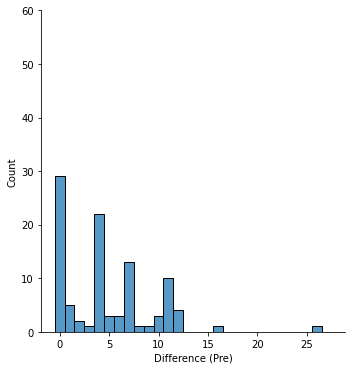

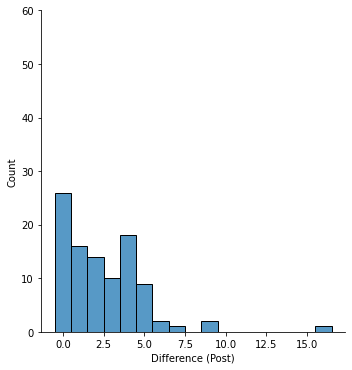

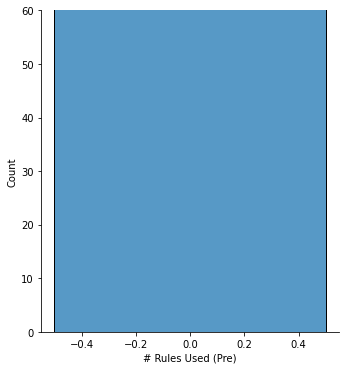

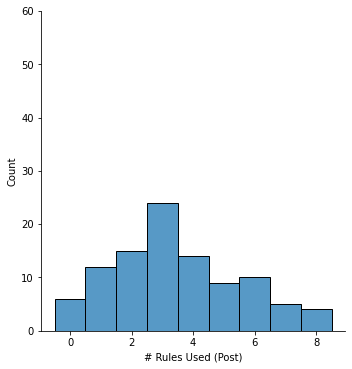

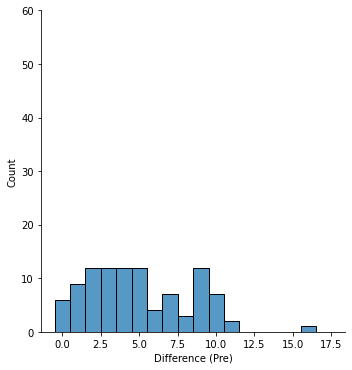

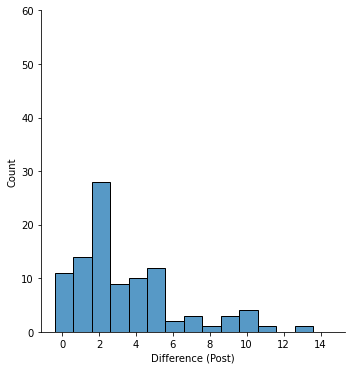

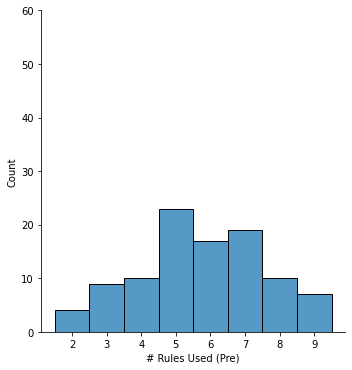

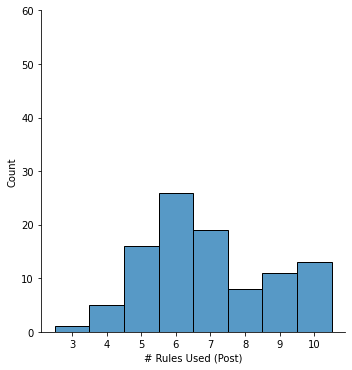

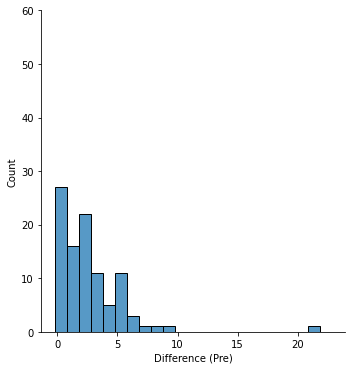

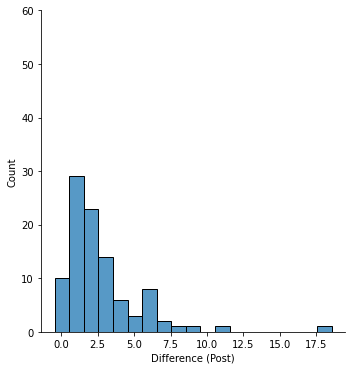

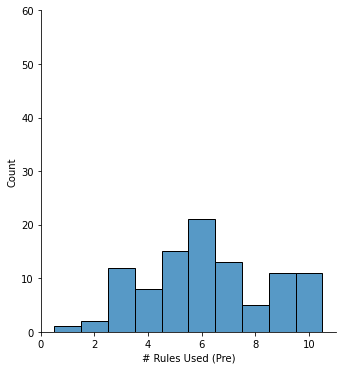

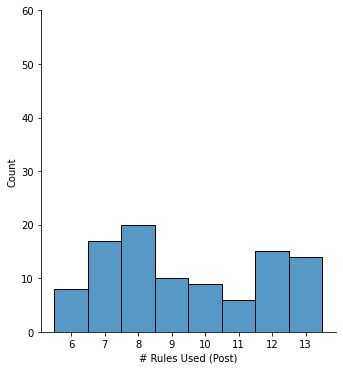

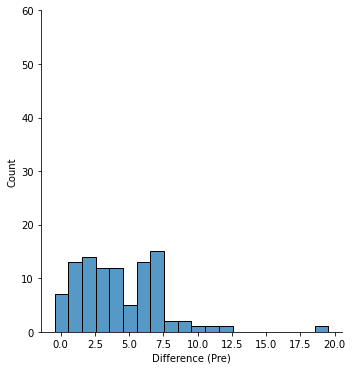

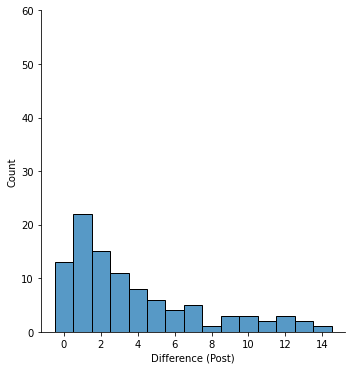

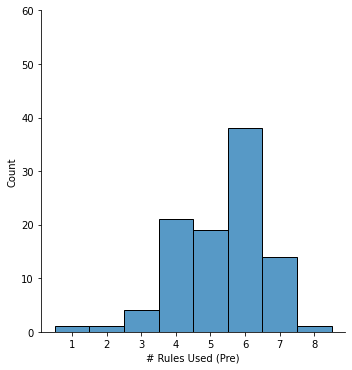

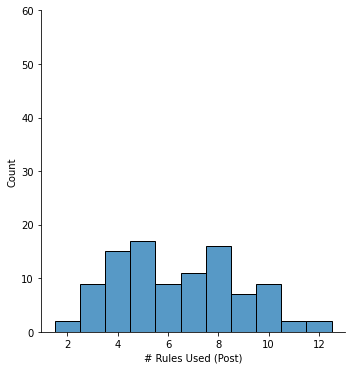

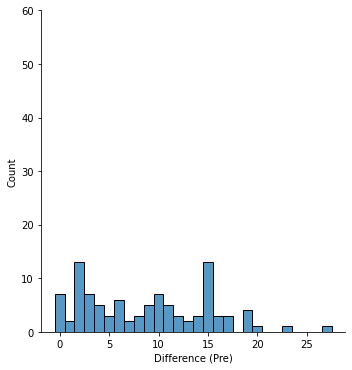

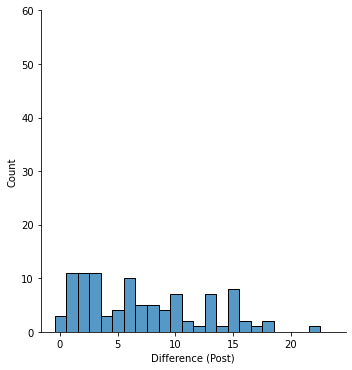

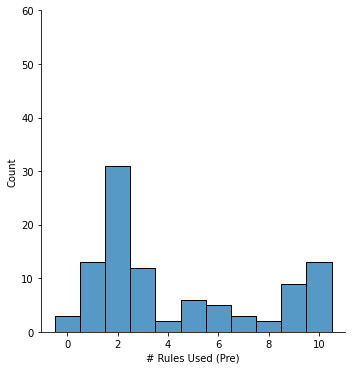

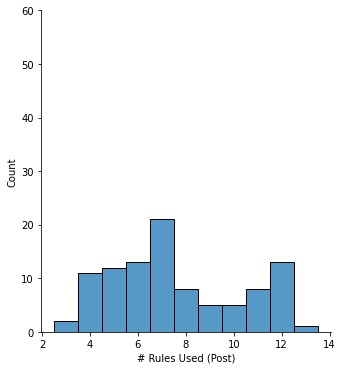

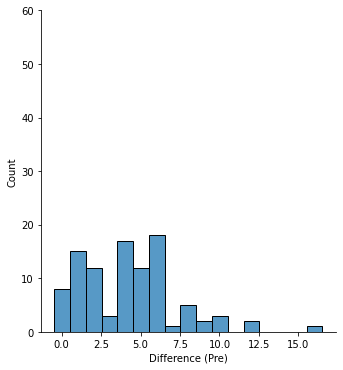

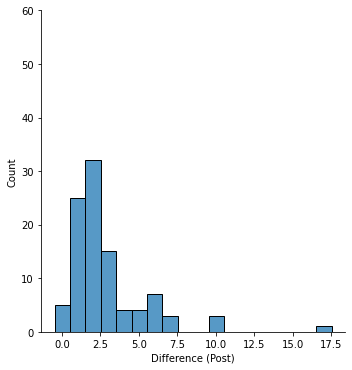

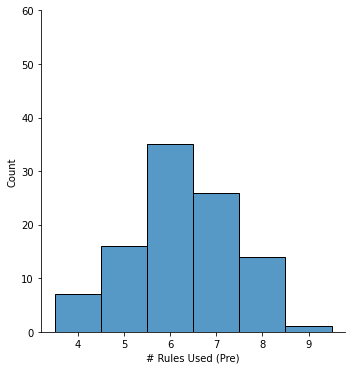

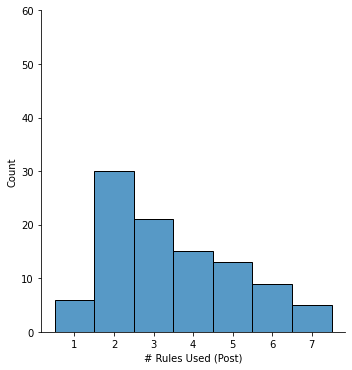

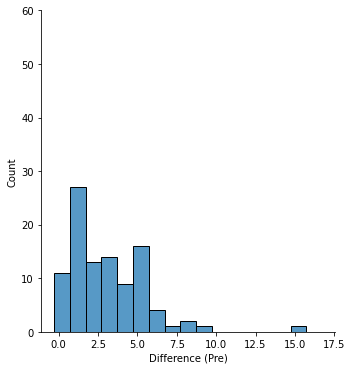

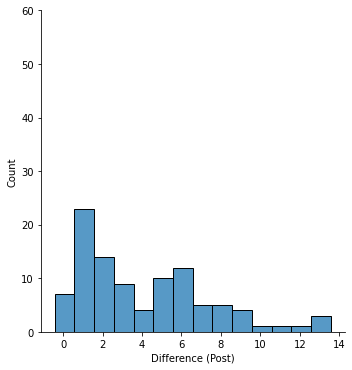

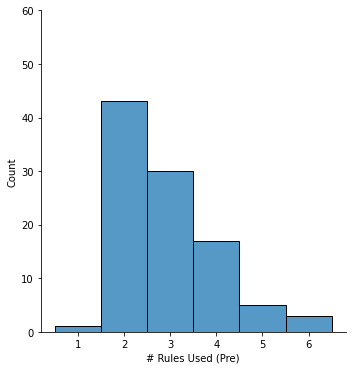

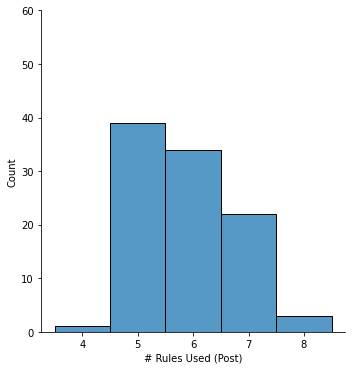

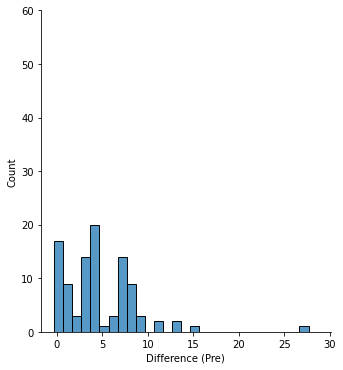

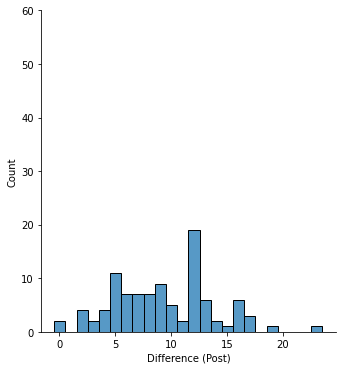

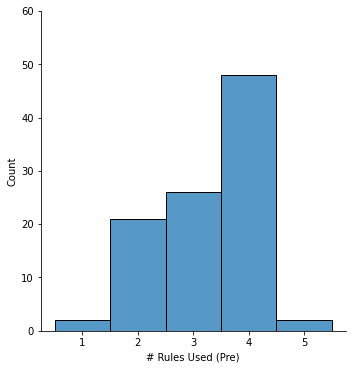

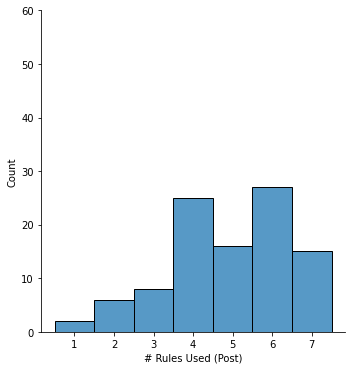

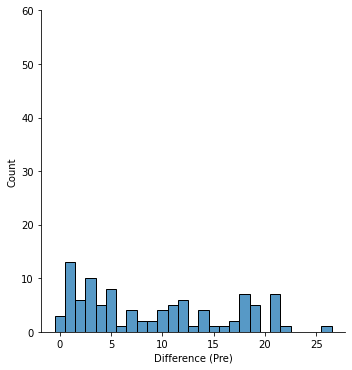

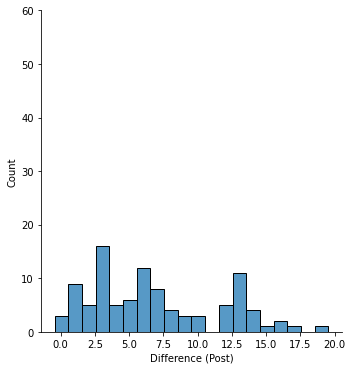

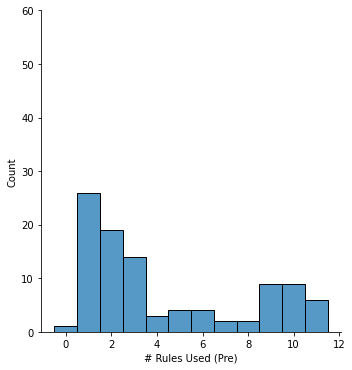

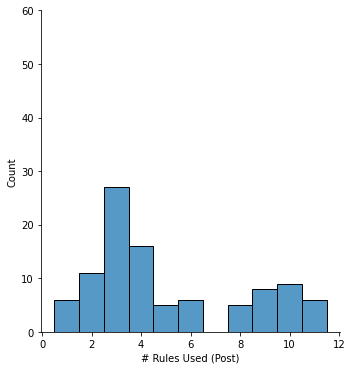

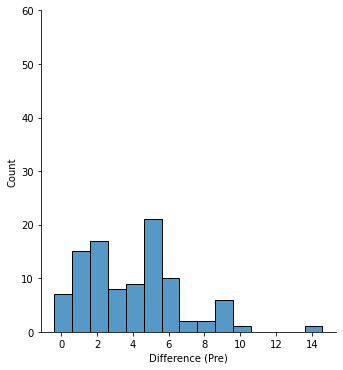

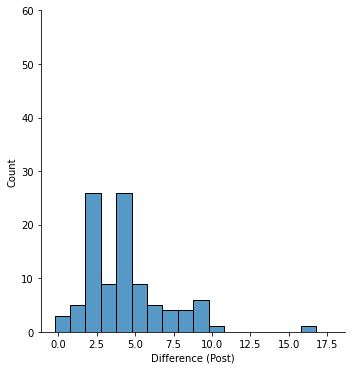

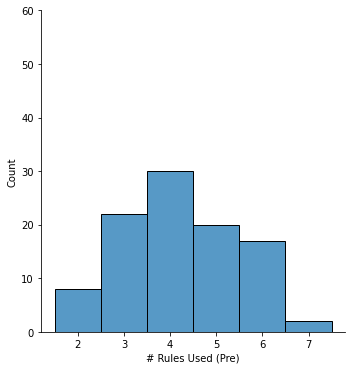

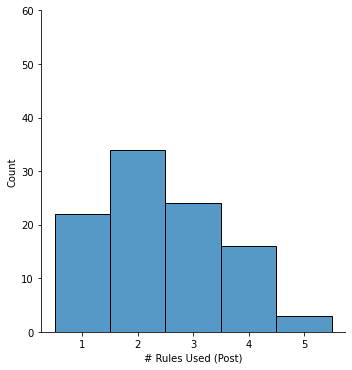

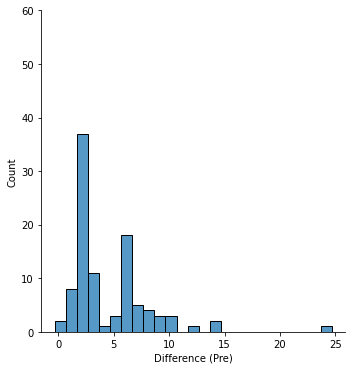

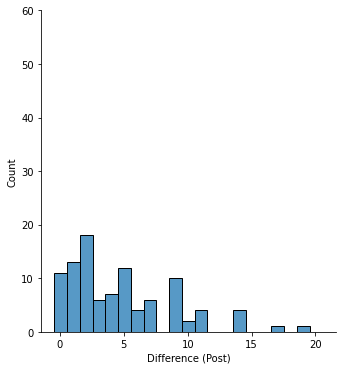

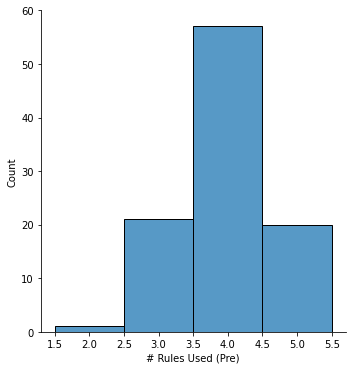

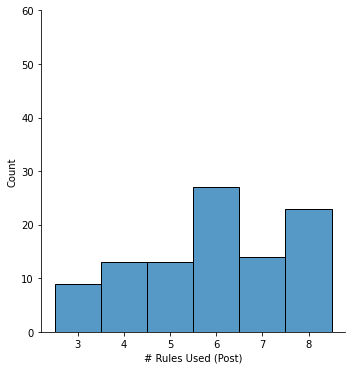

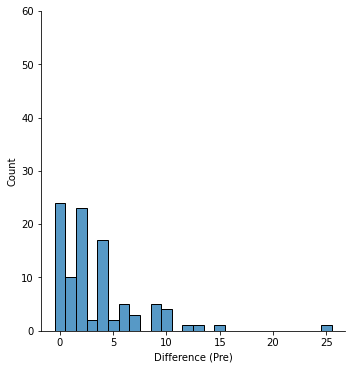

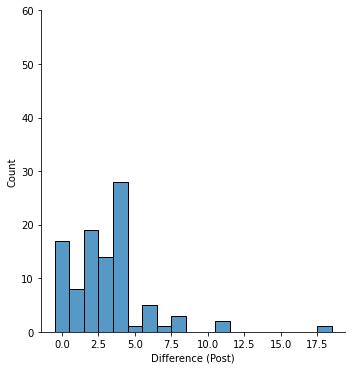

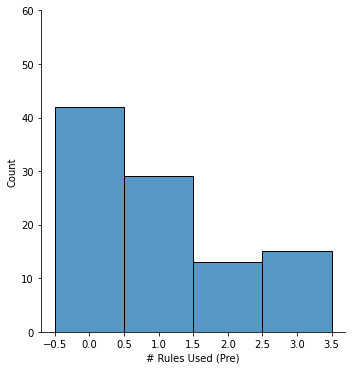

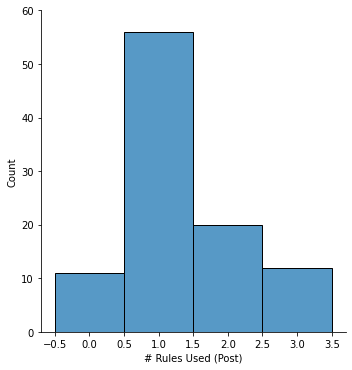

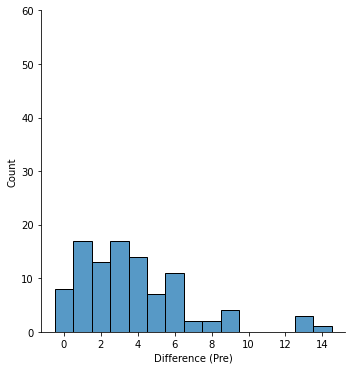

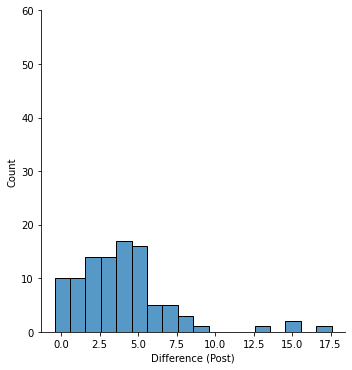

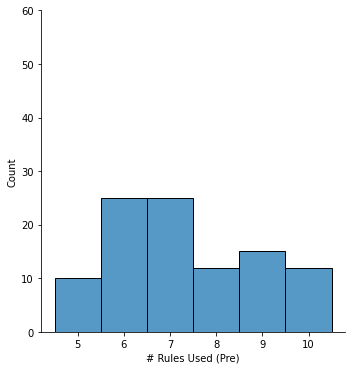

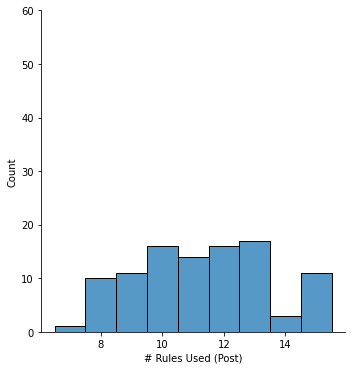

In [ ]:
results = []

for i in range(0, len(rule_set) - 1, 2):
  results.append(calculate_rule_data_set_statistics(rule_set[i], rule_set[i + 1], 4.65, 1.6, 0.3, 0.1))

In [ ]:
convert_results_to_json(results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>